# Analysis of PBMC data from 10x Genomics using scJoint

This tutorial demonstrates the integration analysis of datasets downloaded from 10x Genomics website using scJoint. The scRNA-seq is downloaded via
```
wget https://cf.10xgenomics.com/samples/cell-exp/4.0.0/SC3_v3_NextGem_DI_PBMC_10K/SC3_v3_NextGem_DI_PBMC_10K_filtered_feature_bc_matrix.h5
```
Analysis of quality control, clustering is done to annotate the cell type for scRNA-seq data as training data.
The scATAC-seq data is downloaded via
```
wget https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_10k_v1/atac_pbmc_10k_v1_filtered_peak_bc_matrix.h5
```
and the gene activity matrix is generated by Signac.

In this tutorial, we will starts from reading .h5 files that are processed using tutorial `sce_to_h5.ipynb`. 

In [31]:
import process_db
import h5py
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(1)

In [32]:
rna_h5_files = ["data_10x/exprs_10xPBMC_rna.h5"] 
rna_label_files = ["data_10x/cellType_10xPBMC_rna.csv"] # csv file

atac_h5_files = ["data_10x/exprs_10xPBMC_atac.h5"]
atac_label_files = []

In [33]:
process_db.data_parsing(rna_h5_files, atac_h5_files)

H5 dataset shape: (15463, 9841)
H5 dataset shape: (15463, 6913)


In [34]:
rna_label = pd.read_csv(rna_label_files[0], index_col = 0)
rna_label
print(rna_label.value_counts(sort = False))
process_db.label_parsing(rna_label_files, atac_label_files)

x              
B                   934
CD14+ Monocytes    3113
CD16+ Monocytes     396
DC                  153
Memory CD4+ T      1231
Memory CD8+ T       802
NK                  431
Naive CD4+ T       1395
Naive CD8+ T       1260
Plasma              107
Platelets            19
dtype: int64
{'B': 0, 'CD14+ Monocytes': 1, 'CD16+ Monocytes': 2, 'DC': 3, 'Memory CD4+ T': 4, 'Memory CD8+ T': 5, 'NK': 6, 'Naive CD4+ T': 7, 'Naive CD8+ T': 8, 'Plasma': 9, 'Platelets': 10}


## Running scJoint

The scRNA-seq and scATAC-seq have 15463 genes in common. And we have 11 cell types in total in the scRNA_seq adta, so we will set the number of class as 11 in the config.py file. The paths also needed to be edited accordingly. Here are the settings for integration of scRNA-seq and scATAC-seq from 10x Genomics we used:


```
self.number_of_class = 11 # Number of cell types in scRNA-seq data
self.input_size = 15463 # Number of common genes and proteins between scRNA-seq data and scATAC-seq
self.rna_paths = ['data_10x/exprs_10xPBMC_rna.npz'] # RNA gene expression from scRNA-seq data
self.rna_labels = ['data_10x/cellType_10xPBMC_rna.txt'] # scRNA-seq data cell type labels (coverted to numeric) 
self.atac_paths = ['data_10x/exprs_10xPBMC_atac.npz'] # ATAC gene activity matrix from scATAC-seq data
self.atac_labels = [] 
self.rna_protein_paths = [] 
self.atac_protein_paths = [] 

# Training config            
self.batch_size = 256
self.lr_stage1 = 0.01
self.lr_stage3 = 0.01
self.lr_decay_epoch = 20
self.epochs_stage1 = 20
self.epochs_stage3 = 20
self.p = 0.8
self.embedding_size = 64
self.momentum = 0.9
self.center_weight = 1
self.num_threads = 1
self.seed = 1
self.checkpoint = ''    
```

After modifying `config.py`, we are ready to run scJoint in terminal with
```
python3 main.py
```

This takes ~4 minutes using 1 thread for PyTorch.

## Visualisation

The output files of scJoint are stored in `./output` folder. The embeddings are stored in `*_embeddings.txt` files. Dimension reduction methods like tSNE and UMAP can be applied on the embeddings files for visualisations.

In [35]:
rna_embeddings = np.loadtxt('./output/exprs_10xPBMC_rna_embeddings.txt')
atac_embeddings = np.loadtxt('./output/exprs_10xPBMC_atac_embeddings.txt')
print(rna_embeddings.shape)
print(atac_embeddings.shape)
embeddings =  np.concatenate((rna_embeddings, atac_embeddings))
print(embeddings.shape)
tsne_results = TSNE(perplexity=30, n_iter = 1000).fit_transform(embeddings)
tsne_results.shape
df = pd.DataFrame()
df['tSNE1'] = tsne_results[:,0]
df['tSNE2'] = tsne_results[:,1]

(9841, 64)
(6913, 64)
(16754, 64)


The ATAC-seq prediction results are saved in `*_knn_predictions.txt` which stored the numeric labels of the predictions. The numeric labels can be mapped to the original cell type labels using the `label_to_idx.txt` file in data input folder.

In [36]:
rna_labels = np.loadtxt('./data_10x/cellType_10xPBMC_rna.txt')
atac_predictions = np.loadtxt('./output/exprs_10xPBMC_atac_knn_predictions.txt')
labels =  np.concatenate((rna_labels, atac_predictions))
label_to_idx = pd.read_csv('./data_10x/label_to_idx.txt', sep = '\t', header = None)
label_to_idx.shape
label_dic = []
for i in range(label_to_idx.shape[0]):
    label_dic = np.append(label_dic, label_to_idx[0][i][:-2])

In [37]:
data_label = np.array(["scRNA-seq", "scATAC-seq"])
df['data'] = np.repeat(data_label, [rna_embeddings.shape[0], atac_embeddings.shape[0]], axis=0)
df['predicted'] = label_dic[labels.astype(int)]

<AxesSubplot:xlabel='tSNE1', ylabel='tSNE2'>

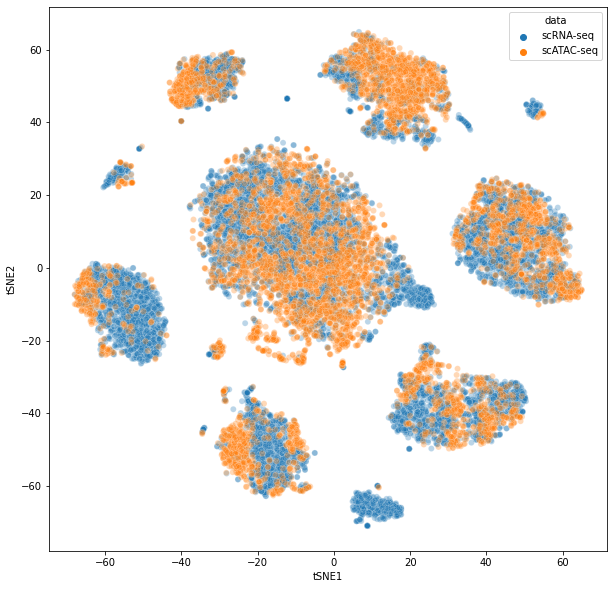

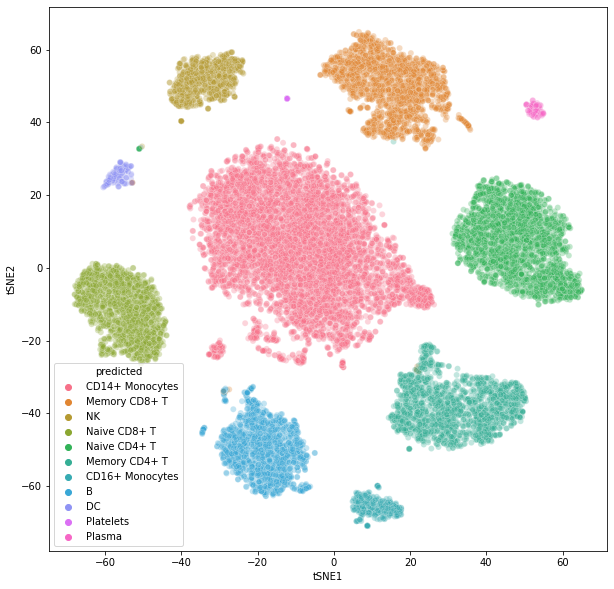

In [38]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x = "tSNE1", y = "tSNE2",
    hue = "data",
    palette = sns.color_palette("tab10", 2),
    data = df,
    legend = "full",
    alpha = 0.3
)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x = "tSNE1", y = "tSNE2",
    hue = "predicted",
    data = df,
    legend = "full",
    alpha = 0.3
)